## 网格搜索

**一个分类问题的网格搜索代码模板，供参考：**

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# 定义折数、评价指标等
def classify_gridsearch_cv(model,
                           X,
                           y,
                           grid,
                           folds=10,
                           n_repeats=3,
                           scoring='accuracy',
                           seed=42):
    # 分类问题使用分层采样
    cv = RepeatedStratifiedKFold(n_splits=folds,
                                 n_repeats=n_repeats,
                                 random_state=seed)
    gs = GridSearchCV(estimator=model,
                      param_grid=grid,
                      n_jobs=-1,
                      cv=cv,
                      scoring=scoring,
                      error_score=0)
    gs = gs.fit(X, y)

    # 最好的模型效果
    print("Best: {:.3f} : {}\n".format(gs.best_score_, gs.best_params_))
    
    # 模型性能统计指标
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("{:.3f} [{:.3f}] : {}".format(mean, stdev, param))
        
    # 返回最好的模型
    return gs.best_estimator_


其中引用库内容学习：

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
# RandomForestRegressor(...)
print(regr.predict([[0, 0, 0, 0]]))

**网络/随机搜索**

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# 选择模型 
model = RandomForestClassifier()
# 参数搜索空间
param_grid = {
    'max_depth': np.arange(1, 20, 1),
    'n_estimators': np.arange(1, 50, 10),
    'max_leaf_nodes': np.arange(2, 100, 10)

}
# 网格搜索模型参数
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(x, y)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
# 随机搜索模型参数
rd_search = RandomizedSearchCV(model, param_grid, n_iter=200, cv=5, scoring='f1_micro')
rd_search.fit(x, y)
print(rd_search.best_params_)
print(rd_search.best_score_)
print(rd_search.best_estimator_)

## XGBoost自动调参工具-使用示例

https://zhuanlan.zhihu.com/p/361724195

乳腺癌数据集--经典的二分类数据集

569个样本，每个样本30个特征(10个平均值，10个标准差，10个最值)，阳性样本357，阴性样本212

In [ ]:
%pip install xgboost

In [ ]:
%pip install xgbtune

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from xgboost import TuneXGB


# 准备数据--乳腺癌数据集
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 调参工具类初始化
tb = TuneXGB(X_train,y_train)
# tb = xgb.TuneXGB(X_train,y_train)


# 查看缺省调参顺序
tb.show_default_order()


# 查看缺省参数
tb.show_default_para()


# 调参过程中随时更新参数
tb.update_cur_params({'n_estimators':180})


# 自定义调参
tb.tune_step({'n_estimators': range(30, 100, 10)},verbose=3)


# 增量调参
tb.tune_sequence()


# 获取当前学习器
tb.get_cur_estimator()


# 查看历史参数和学习器
tb.history_paras
tb.history_estimator


# 进行网格搜索
tb_gs = tb.grid_search({'reg_lambda': [0.01, 0.1, 1.0, 10, 100, 200, 1000]})


# 进行随机搜索
tb_rs = tb.random_search({'colsample_bytree_loc':0.3})


In [ ]:
# 核心数据结构和方法
# 全局初始值重要参数
   cur_params = {
       'colsample_bytree': 1,
       'gamma': 0,
       'learning_rate': 0.1,
       'max_depth': 3,
       'min_child_weight': 1,
       'n_estimators': 100,
       'reg_alpha': 0,
       'reg_lambda': 1,
       'scale_pos_weight': 1,
       'subsample': 1
   }

   
   # 1.缺省的调优顺序流程
   param_grids_list = [
       # 树结构是重点
       # 集成结构--解决偏差
       {
           'n_estimators': range(100, 1000, 50)
       },
       {
           'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1]
       },
       # 树结构参数--解决偏差
       {
           'max_depth': [3, 5, 7, 9, 12, 15, 17, 25]
       },
       {
           'min_child_weight': [1, 3, 5, 7]
       },
       # 树结构(叶子结点)
       {
           'gamma': [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
       },
       # 样本参数--解决方差
       {
           'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
       },
       {
           'colsample_bytree': [0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
       },
       # 正则参数--解决方差
       {
           'reg_alpha': [0, 0.1, 0.5, 1.0, 10, 100, 200, 1000]
       },
       {
           'reg_lambda': [0.01, 0.1, 1.0, 10, 100, 200, 1000]
       }
   ]


1、K折设计：二分类或多分类使用StratifiedKFold；计数类或回归类使用KFold

2、网格搜索：此处统一使用GridSearchCV，也可以使用xgb.cv

3、随机搜索：RandomizedSearchCV；要控制好随机参数的取值范围：根据超参类型进行设定。如

``` python
param_distributions = {
            # np.random.uniform(low=0, high=1) 该函数会更安全:限制在0-1范围
            'colsample_bytree':
            uniform(params.get('colsample_bytree_loc', 0.2),
                    params.get('colsample_bytree_scale', 0.5)),
            
     'max_depth':
            sp_randint(params.get('max_depth_low', 2),
                       params.get('max_depth_high', 11)),
```

4、独立、增量式的搜索，相比全量参数的网格搜索效率会高点，但是最终效果会打折扣,逻辑为顺序调优。主要逻辑如下：
``` python
for pp in TuneXGB.param_grids_list:
            self.tune_step(pp)
            
def tune_step()
    grid_search
```

## BayesianOptimization优化实例

https://zhuanlan.zhihu.com/p/361727389

开源包BayesianOptimization借用了sklearn.gaussian_process实现了基于高斯过程的贝叶斯优化。

- 使用前安装：pip install bayesian-optimization

- GitHub地址: https://github.com/fmfn/BayesianOptimization。

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from bayes_opt import BayesianOptimization


# 定义优化目标
def rfc_cv_object(n_estimators, min_samples_split, max_features, data,
                  targets):
    """随机森林交叉验证

    关注的超参空间：
        n_estimators, min_samples_split, and max_features
    目标：
        最大化指标roc_auc，交叉验证的平均作为最终的模型效果
    """
    estimator = RFC(n_estimators=n_estimators,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    random_state=42)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()


# 定义超参空间和优化器
def optimize_rfc(data, targets):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        """rfc_cv的二次封装，保证：
            1.n_estimators和min_samples_split为整数
            2.避免max_features在(0, 1)范围之外
        """
        return rfc_cv_object(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        # 超参空间
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=42,
        verbose=2)
    # 2个初始化点和10轮优化，共12轮
    optimizer.maximize(init_points=2, n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer


# 调用优化：使用数据
ret = optimize_rfc(X_train, y_train)

In [ ]:
"""
随机森林分类Iris使用贝叶斯优化调参
"""
import numpy as np
from hyperopt import hp, tpe, Trials, STATUS_OK, Trials, anneal
from functools import partial
from hyperopt.fmin import fmin
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

def model_metrics(model, x, y):
    """ 评估指标 """
    yhat = model.predict(x)
    return  f1_score(y, yhat,average='micro')

def bayes_fmin(train_x, test_x, train_y, test_y, eval_iters=50):
    """
    bayes优化超参数
    eval_iters：迭代次数
    """
    
    def factory(params):
        """
        定义优化的目标函数
        """
        fit_params = {
            'max_depth':int(params['max_depth']),
            'n_estimators':int(params['n_estimators']),
            'max_leaf_nodes': int(params['max_leaf_nodes'])
            }
        # 选择模型
        model = RandomForestClassifier(**fit_params)
        model.fit(train_x, train_y)
        # 最小化测试集（- f1score）为目标
        train_metric = model_metrics(model, train_x, train_y)
        test_metric = model_metrics(model, test_x, test_y)
        loss = - test_metric
        return {"loss": loss, "status":STATUS_OK}

    # 参数空间
    space = {
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 2, 50, 1), 
        'max_leaf_nodes': hp.quniform('max_leaf_nodes', 2, 100, 1)
            }
    # bayes优化搜索参数
    best_params = fmin(factory, space, algo=partial(anneal.suggest,), max_evals=eval_iters, trials=Trials(),return_argmin=True)
    # 参数转为整型
    best_params["max_depth"] = int(best_params["max_depth"])
    best_params["max_leaf_nodes"] = int(best_params["max_leaf_nodes"])
    best_params["n_estimators"] = int(best_params["n_estimators"])
    return best_params

#  搜索最优参数
best_params = bayes_fmin(train_x, test_x, train_y, test_y, 100)
print(best_params)

### https://zhuanlan.zhihu.com/p/79616011

## 编程实现精准率和召回率

In [7]:
# 首先生成样本不均衡的数据
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
x = digits.data
y = digits.target.copy()
# 生成不平衡的数据
y[digits.target==9] = 1
y[digits.target!=9] = 0

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)
# 0.9755555555555555
log_reg_predict = log_reg.predict(x_test)
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))

def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))

def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

TN(y_test, log_reg_predict)
# 403
FP(y_test, log_reg_predict)
# 2
FN(y_test, log_reg_predict)
# 9
TP(y_test, log_reg_predict)
# 36
# 混淆矩阵的实现
def confusion_matrix(y_true, y_predict):
    return np.array([
        [TN(y_test, log_reg_predict), FP(y_test, log_reg_predict)],
        [FN(y_test, log_reg_predict), TP(y_test, log_reg_predict)],
    ])
confusion_matrix(y_test, log_reg_predict)
# array([[403,   2],
#       [  9,  36]])
# 精准率
def precison_score(y_true, y_predict):
    tp = TP(y_test, log_reg_predict)
    fp = FP(y_test, log_reg_predict)
    try:
        return tp/(tp+fp)
    except:
        return 0.0

# 召回率
def recall_score(y_true, y_predict):
    tp = TP(y_test, log_reg_predict)
    fn = FN(y_test, log_reg_predict)
    try:
        return tp/(tp+fn)
    except:
        return 0.0

precison_score(y_test, log_reg_predict)
# 0.9473684210526315
recall_score(y_test, log_reg_predict)
# 0.8

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

In [8]:
# sklearn中精准率和召回率的实现
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

confusion_matrix(y_test, log_reg_predict)
# array([[403,   2], [  9,  36]], dtype=int64)
precision_score(y_test, log_reg_predict)
# 0.9473684210526315
recall_score(y_test, log_reg_predict)
# 0.8

0.8

## F1-score编程实现

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

digits = datasets.load_digits()
x = digits.data
y = digits.target.copy()
# 生成不平衡的数据
y[digits.target==9] = 1
y[digits.target!=9] = 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)
# 0.9755555555555555
log_reg_predict = log_reg.predict(x_test)

def f1_score(precision, recall):
    try:
        return 2 * precision * recall / (precision + recall)
    except:
        return 0.0

precision_score(y_test, log_reg_predict)
# 0.9473684210526315
recall_score(y_test, log_reg_predict)
# 0.8
f1_score(precision_score(y_test, log_reg_predict), recall_score(y_test, log_reg_predict))
# 0.8674698795180723

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8674698795180723

In [10]:
# sklearn中的实现：
from sklearn.metrics import f1_score

f1_score(y_test, log_reg_predict)
# 0.8674698795180723

0.8674698795180723

In [11]:
# 精准率和召回率任何一个值比较低就会拉低整体分数。
def f1_score(precision, recall):
    try:
        return 2 * precision * recall / (precision + recall)
    except:
        return 0.0 
    
precision = 0.5
recall = 0.5
f1_score(precision, recall)
# 0.5
precision = 0.1
recall = 0.9
f1_score(precision, recall)
# 0.18000000000000002

0.18000000000000002

### 精准率与召回率的平衡时，更改阈值进行判断

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

digits = datasets.load_digits()
x = digits.data
y = digits.target.copy()
# 生成不平衡的数据
y[digits.target==9] = 1
y[digits.target!=9] = 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
# 默认使用0作为决策边界。那如何对决策边界进行平移呢？
y_predict = log_reg.predict(x_test)

confusion_matrix(y_test, y_predict)
# array([[403,   2],
#       [  9,  36]], dtype=int64)
precision_score(y_test, y_predict)
# 0.9473684210526315
recall_score(y_test, y_predict)
# 0.8

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

In [13]:
log_reg.decision_function(x_test)
# 太多了，显示前10个
log_reg.decision_function(x_test)[:10]

array([-21.39584206, -32.89855272, -16.42651309, -79.82825424,
       -48.0293871 , -24.1797053 , -44.61934871, -24.23691841,
        -1.1444768 , -19.00735388])

In [14]:
decision_score =  log_reg.decision_function(x_test)
np.min(decision_score)
# -85.68608522646575
np.max(decision_score)
# 19.8895858799022

19.91099655206776

In [15]:
y_predict2 = np.array(decision_score >= 5, dtype='int')
confusion_matrix(y_test, y_predict2)
# array([[404,   1],
#        [ 21,  24]], dtype=int64)
precision_score(y_test, y_predict2)
# 0.96
recall_score(y_test, y_predict2)
# 0.5333333333333333

0.5333333333333333

In [16]:
y_predict3 = np.array(decision_score >= -5, dtype='int')
confusion_matrix(y_test, y_predict3)
# array([[390,  15],
#        [  5,  40]], dtype=int64)
precision_score(y_test, y_predict3)
# 0.7272727272727273
recall_score(y_test, y_predict3)
# 0.8888888888888888

0.8888888888888888

### 精准率与召回率曲线（P-R曲线）

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


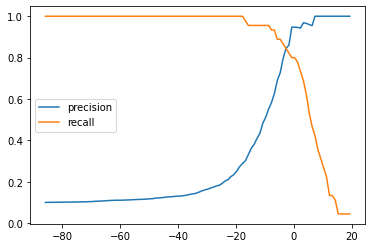

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

digits = datasets.load_digits()
x = digits.data
y = digits.target.copy()
# 生成不平衡的数据
y[digits.target==9] = 1
y[digits.target!=9] = 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

decision_scores = log_reg.decision_function(x_test)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precisions = []
recalls = []
thresholds = np.arange(np.min(decision_scores), np.max(decision_scores))

for threshold in thresholds:
    y_predict = np.array(decision_scores >= threshold, dtype='int')
    precisions.append(precision_score(y_test, y_predict))
    recalls.append(recall_score(y_test, y_predict)) 
    
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.show()

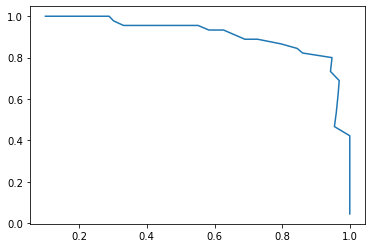

In [3]:
plt.plot(precisions, recalls)
plt.show()

通过图中的趋势很显然随着精准率的提高，召回率在不断的下降。这也再一次印证了精准流程和召回率是互相制约互相平衡的，而在图中急剧下降的点大概就是精准率和召回率平衡的最佳点。

In [4]:
# sklearn中实现P-R曲线
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, decision_scores)
precisions.shape
# (145,)
recalls.shape
# (145,)
thresholds.shape
# (144,)

(150,)

通过上面程序输出结果可以发现返回的精准率和召回率与阈值的长度不一致，这是因为在sklearn中会自动取合适的阈值范围内计算准确率和召回率，而且默认的最大值为1和最小值为0，没有对应的threshold，因此这就是为什么thresholds比precisions和recalls长度少1，因此在绘图的时候需要注意。

通过下面这两条曲线对比自己编程实现的精准率和召回率曲线大致相同，有着略微的差异，这是因为sklearn中对阈值进行了处理,会自动选取最重要的那部分。

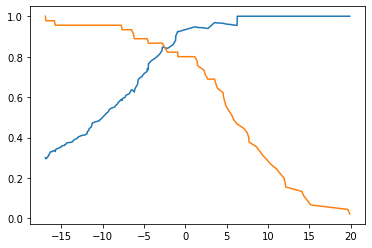

In [5]:
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.show()

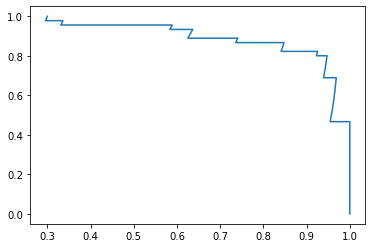

In [6]:
plt.plot(precisions, recalls)
plt.show()

### ROC曲线编程实现

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


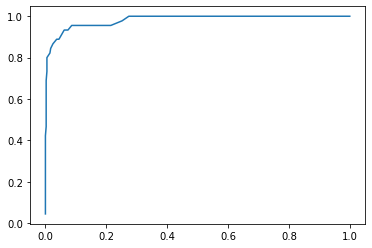

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))

def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))

def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

def TPR(y_true, y_predict):
    tp = TP(y_true, y_predict)
    fn = FN(y_true, y_predict)
    try:
        return tp / (tp + fn)
    except:
        return 0.0
    
def FPR(y_true, y_predict):
    fp = FP(y_true, y_predict)
    tn = TN(y_true, y_predict)
    try:
        return fp / (fp + tn)
    except:
        return 0.0
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
x = digits.data
y = digits.target.copy()
# 生成不平衡的数据
y[digits.target==9] = 1
y[digits.target!=9] = 0

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)
# 0.9755555555555555
log_reg_predict = log_reg.predict(x_test)

decision_scores = log_reg.decision_function(x_test)

fprs = []
tprs = []
thresholds = np.arange(np.min(decision_scores), np.max(decision_scores))

for threshold in thresholds:
    y_predict = np.array(decision_scores >= threshold, dtype='int')
    fprs.append(FPR(y_test, y_predict))
    tprs.append(TPR(y_test, y_predict))
    
plt.plot(fprs, tprs)
plt.show()

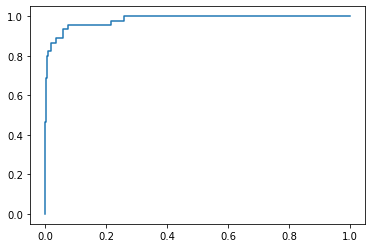

In [8]:
# sklearn中ROC曲线的实现
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = roc_curve(y_test, decision_scores)
plt.plot(fprs, tprs)
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score
# area under curve
roc_auc_score(y_test, decision_scores)
# 0.9830452674897119

0.9823868312757201

### 多分类问题中的混淆矩阵

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
x = digits.data
y = digits.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=666)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)

y_predict = log_reg.predict(x_test)

from sklearn.metrics import precision_score
precision_score(y_test, y_predict, average='micro')
# 可以尝试一下precision_score(y_test, y_predict)，默认情况下是不支持多分类准确率预测的，但是可以通过传入超参数解决
# 0.93115438108484
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

D:\IDE\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[148,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 125,   2,   0,   0,   0,   0,   3,   2,  11],
       [  0,   1, 134,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 138,   0,   5,   0,   1,   4,   0],
       [  2,   4,   0,   0, 138,   0,   1,   3,   0,   2],
       [  1,   2,   1,   0,   0, 146,   1,   0,   0,   1],
       [  0,   2,   0,   0,   0,   1, 132,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0, 135,   0,   1],
       [  0,   8,   2,   1,   3,   3,   0,   1, 120,   2],
       [  0,   1,   0,   6,   0,   1,   0,   1,   1, 137]], dtype=int64)

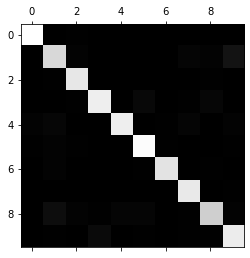

In [11]:
# 这样看上去并不直观，绘制一下混淆矩阵。
import matplotlib.pyplot as plt
cfm = confusion_matrix(y_test, y_predict)
plt.matshow(cfm, cmap=plt.cm.gray)
plt.show()
# 图中白色方框越亮说明预测正确率越高

In [12]:
# 只显示正确率对于混淆矩阵是没有意义的，想看看预测错误部分。

# 计算每一行有多少个样本
row_sums = np.sum(cfm, axis=1)
err_matrix = cfm / row_sums
# 不关注预测正确的那部分
np.fill_diagonal(err_matrix, 0)
err_matrix

array([[0.        , 0.        , 0.00735294, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.01470588, 0.        , 0.        ,
        0.        , 0.        , 0.02205882, 0.01428571, 0.07482993],
       [0.        , 0.00699301, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00714286, 0.        ],
       [0.        , 0.        , 0.00735294, 0.        , 0.        ,
        0.03289474, 0.        , 0.00735294, 0.02857143, 0.        ],
       [0.01342282, 0.02797203, 0.        , 0.        , 0.        ,
        0.        , 0.00735294, 0.02205882, 0.        , 0.01360544],
       [0.00671141, 0.01398601, 0.00735294, 0.        , 0.        ,
        0.        , 0.00735294, 0.        , 0.        , 0.00680272],
       [0.        , 0.01398601, 0.        , 0.        , 0.        ,
        0.00657895, 0.        , 0.        , 0.00714286, 0.        ],
       [0.        , 0.        , 0.       

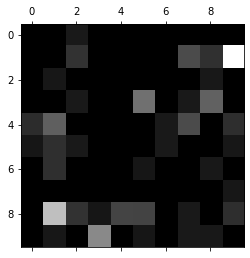

In [13]:
# 上述输出就是预测错误部分，绘制一下矩阵
plt.matshow(err_matrix, cmap=plt.cm.gray)
plt.show()
# 图中整体来说就是越亮的部分就是预测错误越多的地方

---
## k折交叉验证

https://ljalphabeta.gitbooks.io/python-/content/kfold.html

https://blog.csdn.net/cauchy7203/article/details/107162197

GridSearchCV即网格搜索的交叉验证法，这是最为常用的方法之一。在sklearn的官方文档中给出了该方法详细的输入参数和说明，而通常我们只需要考虑以下几个参数即可：

|参数名称	|说明|
|-----------|:-------------:|
|estimator	|被调参的模型，即上一教程中提到的各类模型的class，比如tree,RandomForestRegressor等具体模型，以对象实例的形式传递。|
|param_grid	|被调参数的grid，以字典形式传递。|
|scoring	|模型评价指标，给出具体指标的名称字符串即可，如'accuracy','neg_mean_squared_error'等。|
|cv	      |这个变量比较复杂。一般来说我们直接取整数即可，也就是k-fold中的k即可。特别地当k等于样本个数时，它就是留一法。|

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)
# GridSearchCV(estimator=SVC(), param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

### 如何使用交叉验证进行调参的实际例子

In [15]:
# 第一种情况：只使用训练集测试集测试：
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

digits = datasets.load_digits()
x = digits.data
y = digits.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=666)

best_score, best_p, best_k = 0, 0, 0 
for k in range(2, 11):
    for  p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        knn_clf.fit(x_train, y_train)
        score = knn_clf.score(x_test, y_test)
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print("Best K=", best_k)
print("Best P=", best_p)
print("Best score=", best_score)

Best K= 3
Best P= 2
Best score= 0.9860917941585535


In [16]:
# 第二种情况
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, x_train, y_train)
# array([0.98895028, 0.97777778, 0.96629213])

array([0.99537037, 0.98148148, 0.97685185, 0.97674419, 0.97209302])

In [18]:
best_score, best_p, best_k = 0, 0, 0 
for k in range(2, 11):
    for  p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        scores = cross_val_score(knn_clf, x_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print("Best K=", best_k)
print("Best P=", best_p)
print("Best score=", best_score)

Best K= 2
Best P= 2
Best score= 0.9851507321274763


对比第一种情况，我们发现得到的最优超参数是不一样的，虽然score会稍微低一些，但是一般第二种情况更加可信。但是这个score只是说明这组参数最优，并不是指的是模型对于测试集的准确率，因此接下来看一下准确率。

In [19]:
best_knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=2, p=2)
best_knn_clf.fit(x_train, y_train)
best_knn_clf.score(x_test, y_test)

0.980528511821975

In [21]:
# 要修改交叉验证默认的五份，就再传入一个参数。同样地，下面的网格搜索中的cv也是可以调整的。
cross_val_score(knn_clf, x_train, y_train, cv=3)

array([0.98055556, 0.98050139, 0.96100279])

### 网格搜索中的交叉验证

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {
        'weights':['distance'],
         'n_neighbors':[i for i in range(2, 11)],
        'p':[i for i in range(1, 6)]
    }
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, verbose=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             verbose=1)

In [23]:
grid_search.best_score_
# 0.9823747680890538
grid_search.best_params_
# {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
best_knn_clf = grid_search.best_estimator_
best_knn_clf.score(x_test, y_test)
# 0.980528511821975

# 这跟上面使用交叉验证的到结果一致。

0.980528511821975